## Background

The first part of this project focuses on creating an image denoiser using a CNN autoencoder. The second part builds a VAE which can generate MNIST images. The last section explores the latent space of a VAE.

## 1.1 - Create additive noise transform
Add additive Gaussian noise to the batch of input images. The noise for every pixel should have mean value 0 and standard deviation of 0.3, i.e $ \epsilon \sim N(0, 0.3)$. The values are Clipped between 0 and 1 as they may be outside the range.

In [ ]:
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt

class AddGaussianNoise(object):
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self, tensor):
    noise = torch.randn(tensor.size()) * self.std + self.mean
    noisy_tensor = tensor + noise
    noisy_tensor = torch.clamp(noisy_tensor, 0, 1)
    return noisy_tensor

torch.manual_seed(42)
transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

print(torch.max(train_dataset_noisy.__getitem__(0)[0]).item())
print(torch.min(train_dataset_noisy.__getitem__(0)[0]).item())

noise_0 = train_dataset_noisy.__getitem__(0)[0] - train_dataset_original.__getitem__(0)[0]
noise_1 = train_dataset_noisy.__getitem__(1)[0] - train_dataset_original.__getitem__(1)[0]
print(f'Is added noise different in different images? {not torch.allclose(noise_0, noise_1)}')

1.0
0.0
Is added noise different in different images? True


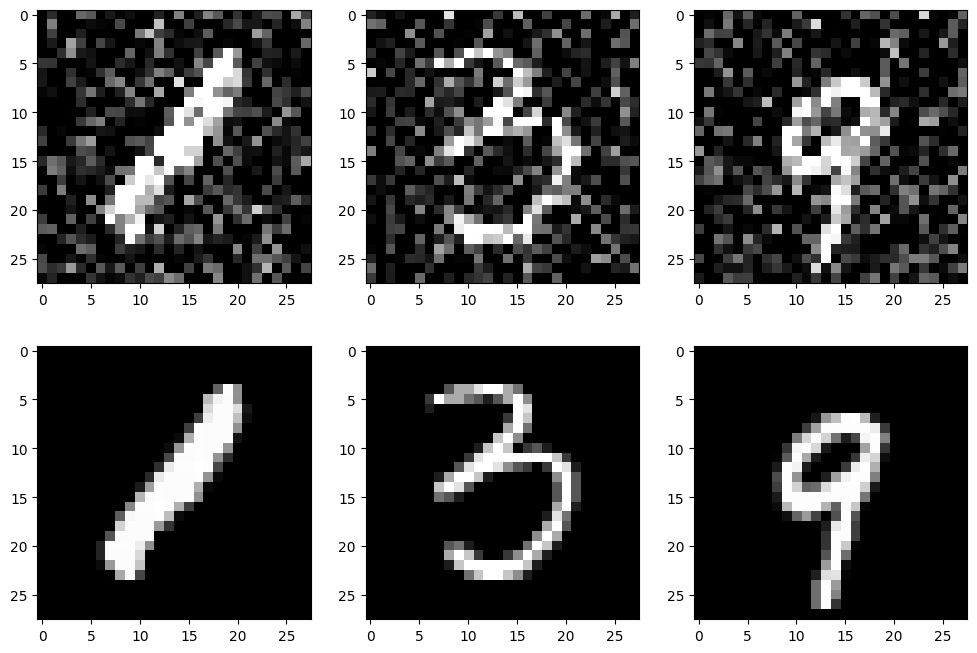

In [ ]:
class ConcatDataset(torch.utils.data.Dataset):
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i][0] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)


batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)

# Plot the first 3 training images with corresponding noisy images
_, (noisy, image) = next(enumerate(train_loader))

fig,ax = plt.subplots(2,3)
fig.set_size_inches(12,8)
for idx in range(3):
  ax[0,idx].imshow(noisy[idx][0], cmap='gray')
  ax[1,idx].imshow(image[idx][0], cmap='gray')
fig.show()

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)

## 1.2 - Create and train a denoising autoencoder

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class our_DAE(nn.Module): # CNN version
  def __init__(self):
    super(our_DAE, self).__init__()

    # Encoder
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(2, stride=2),
    )

    # Decoder
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
        nn.ReLU(True),
        nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
        nn.Sigmoid()
    )

  def forward(self, x):
    # Encode
    x = self.encoder(x)
    # Decode
    x = self.decoder(x)
    return x

DAE = our_DAE().to(device)
optimizer = optim.Adam(DAE.parameters(), lr=2e-4)
loss_fn = nn.MSELoss(reduction='sum')

In [ ]:
# Training and testing code
def train(epoch, device):

  DAE.train() # set the mode for our model

  for batch_idx, (noisy, images) in enumerate(train_loader): # No labels

    optimizer.zero_grad()
    noisy, images = noisy.to(device), images.to(device)
    output = DAE(noisy)
    loss = loss_fn(output, images) # typical loss function (Mean square error)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # record output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 500 == 0: # visulize output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

  DAE.eval() # set the mode for model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for (noisy, images) in test_loader:
      noisy, images = noisy.to(device), images.to(device)
      output = DAE(noisy)
      test_loss += loss_fn(output, images).item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 5
for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)

Epoch 1: [0/60000] Loss: 141.47352600097656
Epoch 1: [32000/60000] Loss: 12.47286605834961
Test result on epoch 1: Avg loss is 8.449910107421875
Epoch 2: [0/60000] Loss: 7.887317180633545
Epoch 2: [32000/60000] Loss: 7.332086086273193
Test result on epoch 2: Avg loss is 6.71996318359375
Epoch 3: [0/60000] Loss: 6.527307987213135
Epoch 3: [32000/60000] Loss: 5.914371490478516
Test result on epoch 3: Avg loss is 6.03073212890625
Epoch 4: [0/60000] Loss: 5.659104347229004
Epoch 4: [32000/60000] Loss: 6.074960231781006
Test result on epoch 4: Avg loss is 5.691289111328125
Epoch 5: [0/60000] Loss: 6.094245910644531
Epoch 5: [32000/60000] Loss: 5.607034206390381
Test result on epoch 5: Avg loss is 5.471193310546875


torch.Size([1000, 1, 28, 28]) torch.Size([1000, 1, 28, 28])


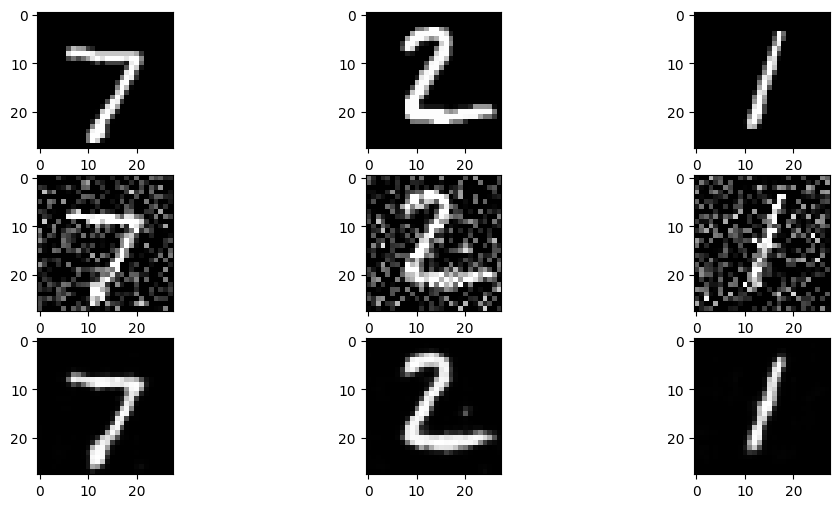

In [ ]:
# Visualization code
import matplotlib.pyplot as plt

_, (noisy, images) = next(enumerate(test_loader))
noisy, images = noisy.to(device), images.to(device)
output = DAE(noisy).cpu().detach()
noisy, images = noisy.cpu(), images.cpu()

print(images.size(), output.size())

fig, ax = plt.subplots(3,3)
fig.set_size_inches(12,6)

for idx in range(3):
  ax[0,idx].imshow(images[idx][0], cmap='gray')
  ax[1,idx].imshow(noisy[idx][0], cmap='gray')
  ax[2,idx].imshow(output[idx][0], cmap='gray')

fig.show()


## 2.1 - Import packages and load MNIST data

In [ ]:
import torchvision
import torch

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # Images already in [0,1]

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)

batch_size_train, batch_size_test = 64, 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)

print(f'We are using device name "{device}"')

We are using device name "cuda"


## 2.2 - VAE Loss function
loss function for VAE:
$$
\begin{aligned}
\textbf{NegativeELBO}(x, g, f) &= \mathbb{E}_{q_f}[-\log p_g(x|z)] + KL(q_f(z|x), p_g(z))\\
 &= \text{ReconstructionLoss} + \text{Regularizer}
\end{aligned}
$$
assuming:
1. $p_g(z)$ is a standard normal distribution.
2. $q_f(z|x)$ is a multivariate Gaussian with trainable mean and variance for each dimension independently.
3. The output distribution of the decoder $p_g(x|z)$ is an independent Bernoulli distribution for every pixel value.

KL divergence:

$$KL(q_f(z|x), p_g(z)) = -\frac{1}{2}\sum_{j=1}^d(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2). $$

In [ ]:
def vae_loss(output, mu, log_var, images):
  """
  :param output: this the output of your neural network
  :param mu: this is the mu from the latent space
  :param log_var: this is the log_var from the latent space
  :param images: this is the original sets of images
  """
  # Calculate the loss
  bce = F.binary_cross_entropy(output, images, reduction='sum')
  kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  return bce, kld


## 2.3 - VAE model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class our_VAE(nn.Module):
  def __init__(self, latent_feature = 16): 
    super(our_VAE, self).__init__()

    self.latent_feature = latent_feature

    # encoder
    self.fc1 = nn.Linear(28*28, 400)
    self.fc21 = nn.Linear(400, latent_feature)
    self.fc22 = nn.Linear(400, latent_feature)

    # decoder
    self.fc3 = nn.Linear(latent_feature, 400)
    self.fc4 = nn.Linear(400, 28*28)

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space
    """
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    sample = mu + eps*std
    return sample

  def encoder(self, x):
    """
    :param x: input distribution
    """
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    mu = self.fc21(x)
    log_var = self.fc22(x)
    z = self.reparameterize(mu, log_var)
    return mu, log_var, z

  def decoder(self, z):
    """
    :param z: latent distribution
    """
    x = F.relu(self.fc3(z))
    x = torch.sigmoid(self.fc4(x))
    x = x.view(-1, 1, 28, 28)
    return x



  def forward(self, x):
    """
    :param x: input variables
    """
    mu, log_var, z = self.encoder(x)
    x = self.decoder(z)
    return x, mu, log_var

In [ ]:
# Check reparameterize method by generating samples
mu_ = [-1.0, 0, 1.0]
var_ = [0.1, 0.2, 0.3]
vae = our_VAE()

torch.manual_seed(42)
for i, (m,v) in enumerate(zip(mu_, var_)):
    m_t = torch.Tensor([m])
    v_t = torch.Tensor([v])
    samples = torch.cat([vae.reparameterize(m_t, torch.log(v_t)) for _ in range(10000)])
    mean = torch.mean(samples)
    var = torch.var(samples)
    print(f'###### Test Case {i+1}: mu = {m}, var = {v} ######')
    print(f'Is mean of the samples close to the actual mean? {torch.allclose(mean, m_t, atol=1e-2)}') # True
    print(f'Is variance of the samples close to the actual variance? {torch.allclose(var, v_t, atol=1e-2)}\n') # True

###### Test Case 1: mu = -1.0, var = 0.1 ######
Is mean of the samples close to the actual mean? True
Is variance of the samples close to the actual variance? True

###### Test Case 2: mu = 0, var = 0.2 ######
Is mean of the samples close to the actual mean? True
Is variance of the samples close to the actual variance? True

###### Test Case 3: mu = 1.0, var = 0.3 ######
Is mean of the samples close to the actual mean? True
Is variance of the samples close to the actual variance? True



## 2.4 Train and validate model

In [ ]:
# Training code
def train(epoch, device, quiet=False):

  VAE.train() # set the mode for model

  for batch_idx, (images, _) in enumerate(train_loader): # No labels

    optimizer.zero_grad()
    output, mu, log_var = VAE(images)
    bce, kld = vae_loss(output, mu, log_var, images) # typical loss function (Mean square error)
    loss = bce + kld
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # record output every 10 batches
      bce_losses.append(bce/batch_size_train)
      kld_losses.append(kld/batch_size_train)
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0 and not quiet: # visulize output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')

# Testing code
def test(epoch, device, quiet=False):

  VAE.eval() # set the mode for model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, _ in test_loader:
      output, mu, log_var = VAE(images)
      bce, kld = vae_loss(output, mu, log_var, images)
      test_loss += bce+kld
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  if not quiet:
    print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

# Running train and test
import torch.optim as optim

VAE = our_VAE()
optimizer = optim.Adam(VAE.parameters(), lr=1e-4)

train_losses = []
train_counter = []
bce_losses = []
kld_losses = []
test_losses = []
test_counter = []
max_epoch = 3

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)

Epoch 1: [0/60000] Loss: 548.7486572265625
Epoch 1: [6400/60000] Loss: 268.89947509765625
Epoch 1: [12800/60000] Loss: 226.05877685546875
Epoch 1: [19200/60000] Loss: 220.2144012451172
Epoch 1: [25600/60000] Loss: 215.75119018554688
Epoch 1: [32000/60000] Loss: 193.33399963378906
Epoch 1: [38400/60000] Loss: 186.40777587890625
Epoch 1: [44800/60000] Loss: 183.00051879882812
Epoch 1: [51200/60000] Loss: 171.36590576171875
Epoch 1: [57600/60000] Loss: 157.4611358642578
Test result on epoch 1: Avg loss is 168.56698608398438
Epoch 2: [0/60000] Loss: 169.01934814453125
Epoch 2: [6400/60000] Loss: 166.0917510986328
Epoch 2: [12800/60000] Loss: 158.50315856933594
Epoch 2: [19200/60000] Loss: 169.87892150878906
Epoch 2: [25600/60000] Loss: 157.8376922607422
Epoch 2: [32000/60000] Loss: 150.8896942138672
Epoch 2: [38400/60000] Loss: 157.57421875
Epoch 2: [44800/60000] Loss: 155.48471069335938
Epoch 2: [51200/60000] Loss: 154.5649871826172
Epoch 2: [57600/60000] Loss: 144.83096313476562
Test res

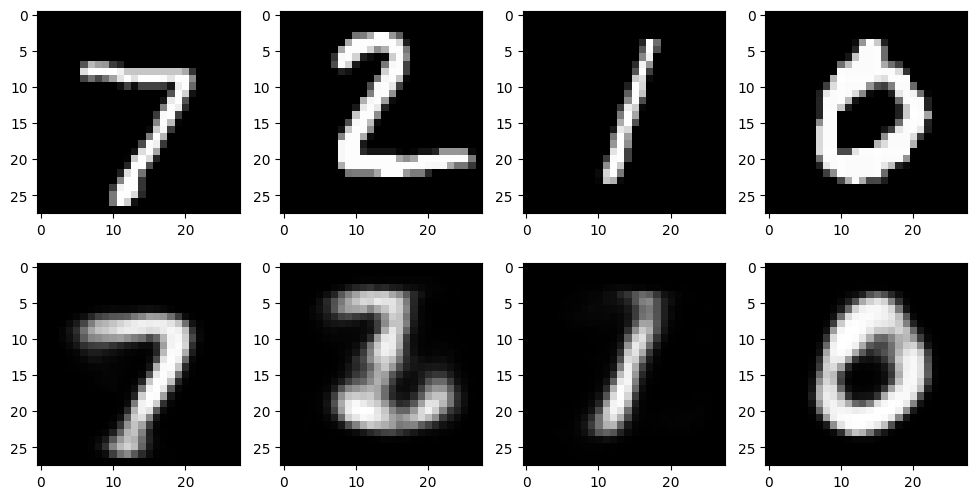

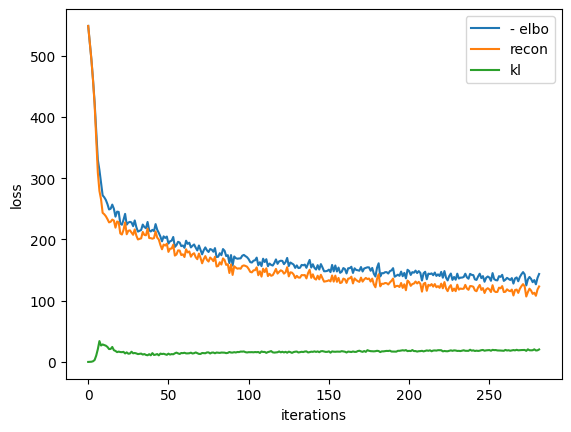

In [ ]:
# Visualization code
import matplotlib.pyplot as plt

batch_idx, (images, _) = next(enumerate(test_loader))
output = VAE(images)[0].detach()
images = images.cpu()


fig, ax = plt.subplots(2,4)
fig.set_size_inches(12,6)

for idx in range(4):
  ax[0,idx].imshow(images[idx][0], cmap='gray')
  ax[1,idx].imshow(output[idx][0], cmap='gray')

fig.show()

plt.figure()
plt.plot(train_losses,label = '- elbo')
plt.plot([i.item() for i in bce_losses],label = 'recon')
plt.plot([i.item() for i in kld_losses],label = 'kl')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

## 3.1 - Latent space of VAE

The latent space will change over time during training as the networks learn which features of the input are most important.  In the beginning, the reconstruction error will be poor and the latent space will be mixed up (i.e., it has not identified good features for dimensionality reduction and then reconstruction).  However, as it continues to train, the space will begin to show some structure (similar to in PCA) as it finds features that enable good reconstruction even after adding a little noise.

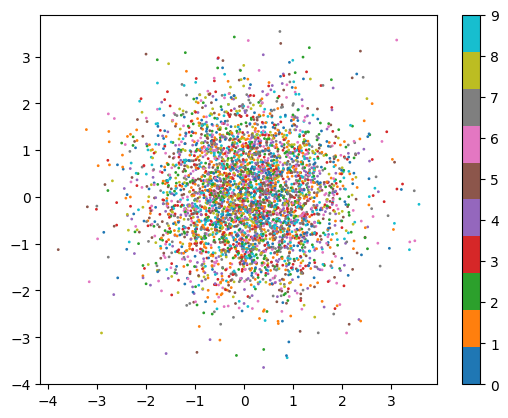

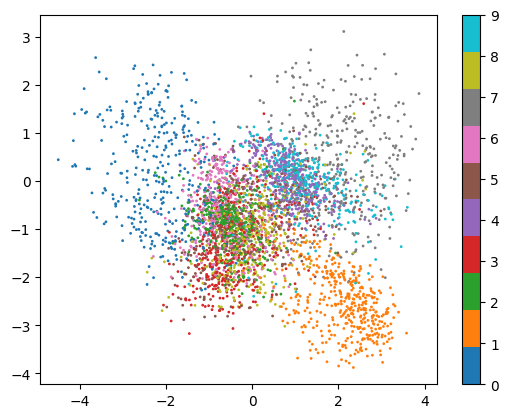

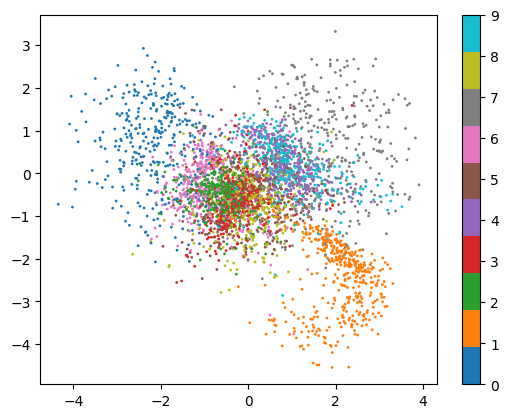

In [ ]:
def plot_latent(vae, data_loader, num_batches=2):
  with torch.no_grad():
    for ibx, (images,label) in enumerate(data_loader):
      _,_,z = vae.encoder(images)
      z = z.to('cpu').detach().numpy()
      plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10',s=1)
      if ibx > num_batches:
        break
  plt.colorbar()
  plt.show()

import torch.optim as optim

VAE = our_VAE(latent_feature=2)
optimizer = optim.Adam(VAE.parameters(), lr=1e-4)

train_losses = []
train_counter = []
bce_losses = []
kld_losses = []
test_losses = []
test_counter = []
max_epoch = 10

plot_latent(VAE, test_loader)
for epoch in range(1, max_epoch+1):
  train(epoch, device=device, quiet=True)
  test(epoch, device=device, quiet=True)
  if epoch == 5 or epoch == 10:
    plot_latent(VAE, test_loader)

## 3.2 - Interpolation of latent space

Interpolation can be quite useful for autoencoder models. For example, by linearly interpolating (or mixing) codes in latent space and decoding the result, the autoencoder can produce a more **semantically meaningful**
combination of the corresponding datapoints than linear interpolation in the raw pixel space.
Besides, in some cases, interpolation experiments can show that the model has learned a latent space with a particular structure. Specifically, if interpolation between points in the latent space shows a smooth semantic warping in the original image space, then the visualization may suggest that similar points are semantically clustered in the latent space.

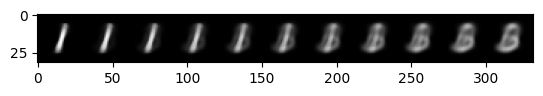

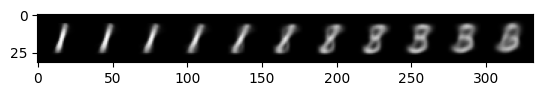

In [ ]:
def linear_interpolation(x0, x1):
  # The output x_interp is a tensor that has shape (11, 1, 28, 28)
  alphas = torch.linspace(0, 1, 11)[:, None, None, None]
  x_interp = alphas * x1 + (1 - alphas) * x0
  return x_interp

def latent_linear_interpolation(z0, z1, VAE):
  # The output x_interp_latent is a tensor that has shape (11, 1, 28, 28)
  alphas = torch.linspace(0, 1, 11)[:, None]
  z_interp = alphas * z1 + (1 - alphas) * z0
  x_interp_latent = VAE.decoder(z_interp)
  return x_interp_latent

import numpy as np
with torch.no_grad():
  images,label = next(enumerate(test_loader))[1]
  #print(images.shape)
  _,_,z = VAE.encoder(images)
  z = z.to('cpu').detach().numpy()
  z0 = z[label==1][0]
  z1 = z[label==8][0]
  x0 = VAE.decoder(torch.Tensor(z0))
  x1 = VAE.decoder(torch.Tensor(z1))

  # Visualize linear interpolation in x space
  xp = linear_interpolation(x0, x1)
  grid_img = torchvision.utils.make_grid(xp, nrow=11)
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.show()

  # Visualize latent linear interpolation in z space that has been reconstructed in x space
  xzp = latent_linear_interpolation(z0, z1, VAE)
  grid_img = torchvision.utils.make_grid(xzp, nrow=11)
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.show()